# Batch Independent Multioutput GP

## Introduction

This notebook demonstrates how to wrap independent GP models into a convenient Multi-Output GP model.
It uses batch dimensions for efficient computation. Unlike in the [Multitask GP Example](./Multitask_GP_Regression.ipynb), this do not model correlations between outcomes, but treats outcomes independently.

This type of model is useful if 
- when the number of training / test points is equal for the different outcomes
- using the same covariance modules and / or likelihoods for each outcome

For non-block designs (i.e. when the above points do not apply), you should instead use a `ModelList` GP as described in the [ModelList multioutput example](./ModelList_GP_Regression.ipynb).

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

## Define a batch GP model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Exact_GPs/Simple_GP_Regression.ipynb).
The differences:

1. The model will use the batch dimension to learn multiple independent GPs simultaneously.
1. We're going to give the mean and covariance modules a `batch_shape` argument. This allows us to learn different hyperparameters for each model.
1. The model will return a `MultitaskMultivariateNormal` distribution rather than a `MultivariateNormal`. We will construct this distribution to convert the batch dimensions into distinct outputs.

In [5]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = BatchIndependentMultitaskGPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 122.929
Iter 2/50 - Loss: 119.192
Iter 3/50 - Loss: 115.233
Iter 4/50 - Loss: 111.096
Iter 5/50 - Loss: 106.824
Iter 6/50 - Loss: 102.458
Iter 7/50 - Loss: 98.038
Iter 8/50 - Loss: 93.608
Iter 9/50 - Loss: 89.226
Iter 10/50 - Loss: 84.959
Iter 11/50 - Loss: 80.849
Iter 12/50 - Loss: 76.895
Iter 13/50 - Loss: 73.049
Iter 14/50 - Loss: 69.255
Iter 15/50 - Loss: 65.470
Iter 16/50 - Loss: 61.671
Iter 17/50 - Loss: 57.848
Iter 18/50 - Loss: 54.001
Iter 19/50 - Loss: 50.137
Iter 20/50 - Loss: 46.268
Iter 21/50 - Loss: 42.412
Iter 22/50 - Loss: 38.591
Iter 23/50 - Loss: 34.830
Iter 24/50 - Loss: 31.155
Iter 25/50 - Loss: 27.596
Iter 26/50 - Loss: 24.183
Iter 27/50 - Loss: 20.947
Iter 28/50 - Loss: 17.915
Iter 29/50 - Loss: 15.109
Iter 30/50 - Loss: 12.543
Iter 31/50 - Loss: 10.213
Iter 32/50 - Loss: 8.110
Iter 33/50 - Loss: 6.225
Iter 34/50 - Loss: 4.556
Iter 35/50 - Loss: 3.111
Iter 36/50 - Loss: 1.903
Iter 37/50 - Loss: 0.948
Iter 38/50 - Loss: 0.252
Iter 39/50 - Loss: -0.

### Make predictions with the model

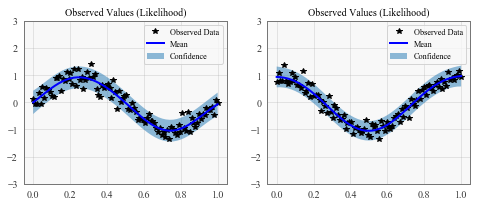

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None